* *Before running this notebook in local, consider the RAM capacity and cores' number of your laptop since the processes which are performed, are memory and CPU intensive.*

# 1. Loading required libraries

In [115]:
# Basic librairies
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from unidecode import unidecode
import re, gc

# Machine learning librairies
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor

# Deep learning librairies
from tensorflow.keras.layers import Input, Dense, Concatenate
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Model
import tensorflow as tf

# 2. Loading data

*Some corrections (bad columns' names, tabulation, ...) have been done to the data before loading it.*

*During export, we let Python choose each column data types for now...*

In [62]:
data = pd.read_csv(filepath_or_buffer=r"books_new.csv")

*We display the rows, and columns.*

In [63]:
data.shape

(11127, 12)

In [64]:
data.head(1)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling / Mary GrandPré,4.57,439785960,9.780000e+12,eng,652,2095690,27591,9/16/2006,Scholastic Inc.


# 3. Feature engineering

*We review data types for each column (to notice if they were chosen correctly by Python or not), and eventually analyze if there are missing values.*

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11127 non-null  int64  
 1   title               11127 non-null  object 
 2   authors             11127 non-null  object 
 3   average_rating      11127 non-null  float64
 4   isbn                11127 non-null  object 
 5   isbn13              11127 non-null  float64
 6   language_code       11127 non-null  object 
 7   num_pages           11127 non-null  int64  
 8   ratings_count       11127 non-null  int64  
 9   text_reviews_count  11127 non-null  int64  
 10  publication_date    11127 non-null  object 
 11  publisher           11127 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 1.0+ MB


*We try to understand the meaning behind the values in the dataset.*

In [66]:
data.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11127.000000,11127.000000,1.112700e+04,11127.000000,1.112700e+04,11127.000000
mean,21310.938887,3.933631,9.759178e+12,336.376921,1.793641e+04,541.854498
std,13093.358023,0.352445,4.428650e+11,241.127305,1.124794e+05,2576.176608
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10287.000000,3.770000,9.780000e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780000e+12,299.000000,7.450000e+02,46.000000
75%,32104.500000,4.135000,9.780000e+12,416.000000,4.993500e+03,237.500000
max,45641.000000,5.000000,9.790000e+12,6576.000000,4.597666e+06,94265.000000


*At this step, some facts must be taken into account for this dataset before further proceeding :*

*a. The columns bookID, isbn, isbn13 won't be considered for further analysis in our context : they represented unique identifiers for each sample/row of the dataset (useful when in the context working with a relational database). Even the books' title are unique identifiers of each row, but we won't discard it since it would help later to build special machine learning models.*

*b. Keeping only the year from the long date format in the column publication_date.*

*c. Having average_rate, num_pages or ratings_count equal to zero is a bit troublesome.*

    A book without pages (num_pages = 0)  can't be rated (ratings_count = 0), and average_rating = 0 is normal.
    if ratings_count = 0, it means the book wasn't reviewed (maybe because num_pages = 0) so its average_rating will also be equal to 0.
    average_rating = 0 can mean the book was rated 0 by all the reviewers (the book's subject was bad); or it can be a value meant to replace missing average_rating values; or it can also correspond to a case for ratings_count = 0 or num_pages = 0.

*d. We must investigate and eventually drop the data' samples corresponding to point c; they can be outliers (special_cases).*

*e. We can have text_reviews_count equal to 0 : it means that even if the book was rated, no written text/comment on the book was done by at least a reviewer.*

In [67]:
_ = ["bookID", "isbn", "isbn13"]
df = data.drop(labels=_, axis=1, inplace=False)

df["publication_year"] = df["publication_date"].apply(lambda x: int(x.split("/")[-1]))
del df['publication_date']

df.head(1)

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publisher,publication_year
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling / Mary GrandPré,4.57,eng,652,2095690,27591,Scholastic Inc.,2006


In [68]:
# Special cases for average_rating = 0, or num_pages = 0, or ratings_count = 0
special_cases = df[((df["average_rating"]==0) | (df["num_pages"]==0) | (df["ratings_count"]==0))]
special_cases.shape

(156, 9)

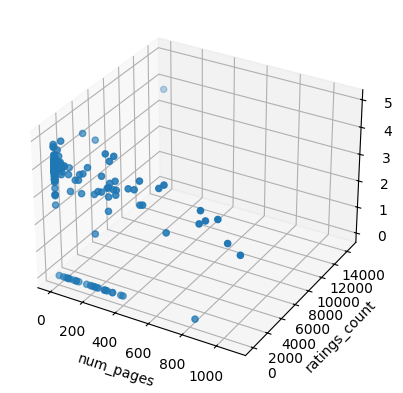

In [69]:
# Investigate these special cases
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(xs=special_cases["num_pages"], ys=special_cases["ratings_count"], zs=special_cases["average_rating"])
ax.set_xlabel('num_pages')
ax.set_ylabel('ratings_count')
ax.set_zlabel('average_rating')
plt.show()

*The special_cases dataset has some incoherent informations such as :* 

*Books with num_pages = 0 (x = 0) , but have ratings_count > 0 and average_rating (z > 0)*

*We won't take into account these special_cases since they have some incoherent informations, and globally it's only amount 1.5% of the original dataset.*

In [70]:
# Normal cases without average_rating = 0, num_pages = 0 and ratings_count = 0
cols = ['average_rating', 'num_pages', 'ratings_count']
normal_cases = df.copy(deep=True)
for col in cols:
    normal_cases = normal_cases[~(normal_cases[col]==0)]
del col, cols, df, scatter, ax, fig
normal_cases.shape

(10971, 9)

In [71]:
normal_cases.describe()

,average_rating,num_pages,ratings_count,text_reviews_count,publication_year
count,10971.000000,10971.000000,1.097100e+04,10971.000000,10971.000000
mean,3.943235,339.064990,1.818883e+04,549.457205,2000.183939
std,0.294536,240.173871,1.132562e+05,2593.630924,8.200245
min,1.000000,1.000000,1.000000e+00,0.000000,1900.000000
25%,3.780000,197.000000,1.130000e+02,10.000000,1998.000000
50%,3.960000,302.000000,7.810000e+02,48.000000,2003.000000
75%,4.140000,416.000000,5.138000e+03,244.000000,2005.000000
max,5.000000,6576.000000,4.597666e+06,94265.000000,2020.000000


In [72]:
# The original dataset becomes normal_cases
data = normal_cases
del normal_cases, special_cases

In [73]:
data.columns

Index(['title', 'authors', 'average_rating', 'language_code', 'num_pages',
       'ratings_count', 'text_reviews_count', 'publisher', 'publication_year'],
      dtype='object')

*The dataset data has 4 qualitative, and 5 quantitative features.*

        Qualitative features :  title, authors, language_code, publisher.
        Quantitative features : average_rating, num_pages, ratings_count, text_reviews_count, publication_year.

## 4. Data analysis

#### Qualitative features univariate analysis


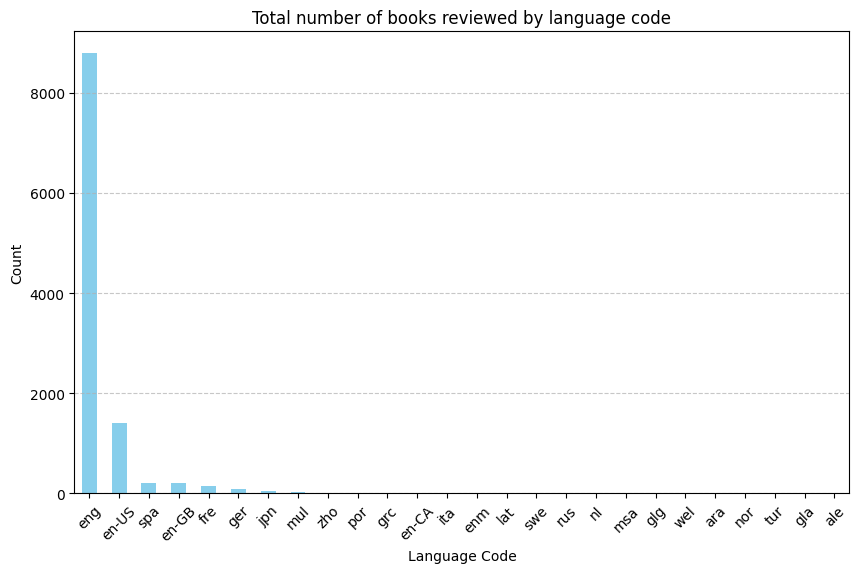

In [74]:
# language_code
_ = data["language_code"].value_counts()
plt.figure(figsize=(10, 6))
_.plot(kind='bar', color='skyblue')
plt.title('Total number of books reviewed by language code')
plt.xlabel('Language Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [75]:
_ = ['eng', 'en-US', 'en-GB', 'en-CA']
data[data["language_code"].isin(_)].shape[0] / data.shape[0]

0.9484094430772035

*Most of the books reviewed (94.84%) in our dataset have been writen in English. This can a result of the fact that most of the reviewers' native language was English.*

In [76]:
# authors

In [77]:
# publisher

#### Quantitative features univariate analysis

In [78]:
# publication_year
data["publication_year"].describe()

count    10971.000000
mean      2000.183939
std          8.200245
min       1900.000000
25%       1998.000000
50%       2003.000000
75%       2005.000000
max       2020.000000
Name: publication_year, dtype: float64

*Only 25% of the books reviewed were written before 1998 (earlier twenties) : their publication years vary between 1900 and 1998 (a difference of 99 years).*

*Another 25% were written between 1998 and 2003 (a difference of 6 years), but the most noticed fact is that books written between 2003 and 2005 (just 3 years of difference) also represented another 25%.* 

*The last 25% are for books written between 2005 and 2020.*

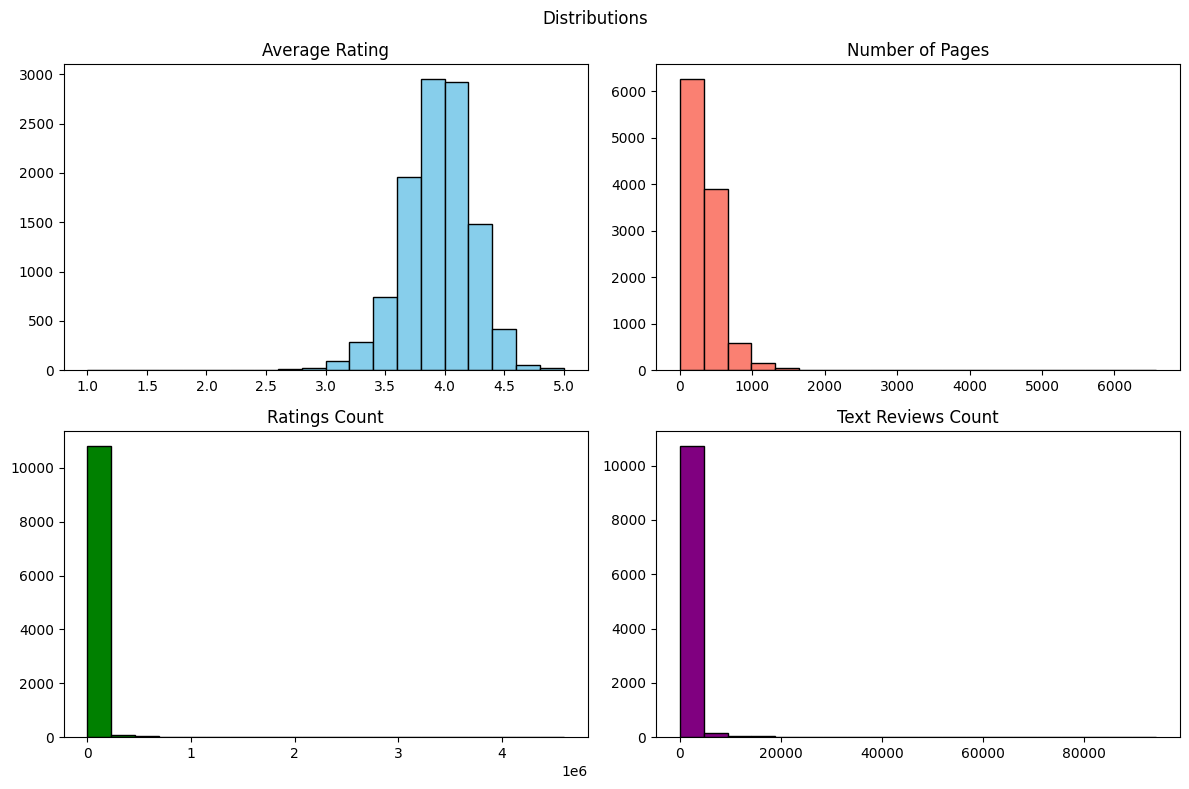

In [79]:
# average_rating, num_pages, ratings_count, text_reviews_count
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].hist(data['average_rating'], bins=20, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Average Rating')
axs[0, 1].hist(data['num_pages'], bins=20, color='salmon', edgecolor='black')
axs[0, 1].set_title('Number of Pages')
axs[1, 0].hist(data['ratings_count'], bins=20, color='green', edgecolor='black')
axs[1, 0].set_title('Ratings Count')
axs[1, 1].hist(data['text_reviews_count'], bins=20, color='purple', edgecolor='black')
axs[1, 1].set_title('Text Reviews Count')

fig.suptitle('Distributions')

plt.tight_layout()
plt.show()

In [80]:
del fig, axs

In [81]:
data[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']].describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,10971.000000,10971.000000,1.097100e+04,10971.000000
mean,3.943235,339.064990,1.818883e+04,549.457205
std,0.294536,240.173871,1.132562e+05,2593.630924
min,1.000000,1.000000,1.000000e+00,0.000000
25%,3.780000,197.000000,1.130000e+02,10.000000
50%,3.960000,302.000000,7.810000e+02,48.000000
75%,4.140000,416.000000,5.138000e+03,244.000000
max,5.000000,6576.000000,4.597666e+06,94265.000000


*The num_pages, ratings_count, text_reviews_count have right skewed distributions. High values seems to be present after third quartile especially for ratings_count and text_reviews_count, this can be an explanation to why these two distributions' means are greater than their third quartiles. Generally for all these distributions, the max value is really high : it amounts at least 15 times the third quartile.*

*The average_rating tends to be symetric (which is the reason why the mean and the median are very close) and less skewed.*

#### Qualitative features multivariate analysis

C:\Users\acoue\AppData\Local\Temp\ipykernel_24068\403249147.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['language_code'], y=data['average_rating'], palette='viridis')


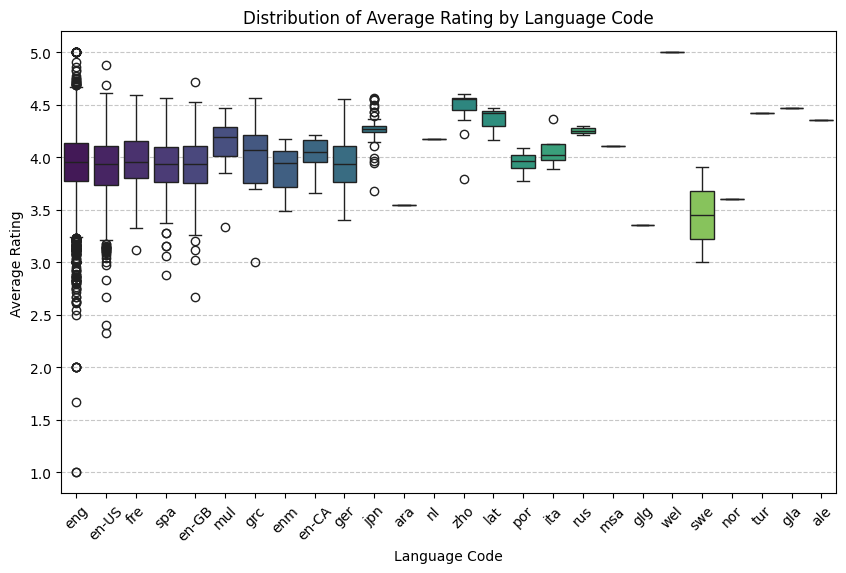

In [82]:
# language_code vs average_rating
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['language_code'], y=data['average_rating'], palette='viridis')
plt.title('Distribution of Average Rating by Language Code')
plt.xlabel('Language Code')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

*The lowest average_rating was given to a book written in english, but still for the same language there was a book with a max average_rating of 5.*

*If we take into account only languages with the most books (eng, en-US, fre, spa, en-GB), we cannot especially differentiate languages with only high average_rating from those with low average_rating.*

In [83]:
# authors vs average_rating

In [84]:
# publisher vs average_rating

#### Quantitative features mutivariate analysis

In [85]:
# publication_year, num_pages, ratings_count, text_reviews_count vs average_rating
data[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_year']].corr()

,average_rating,num_pages,ratings_count,text_reviews_count,publication_year
average_rating,1.000000,0.170746,0.040815,0.033764,-0.046053
num_pages,0.170746,1.000000,0.032975,0.035104,-0.022084
ratings_count,0.040815,0.032975,1.000000,0.865931,0.044832
text_reviews_count,0.033764,0.035104,0.865931,1.000000,0.067372
publication_year,-0.046053,-0.022084,0.044832,0.067372,1.000000


*No high correlation was found between one of the quantitative feature and average_rating : correlations' absolute values are less than 0.5.*

*If we use only these quantitative variables to explain average_rating, the fear is our models won't perform well.*

## 5. Split data into training and test sets

In [86]:
arrays = (data.drop(columns=['average_rating']), data['average_rating'])
X_train, X_test, y_train, y_test = train_test_split(*arrays, test_size=0.3, random_state=123)
del arrays

In [87]:
train_indexes = list(X_train.index)
test_indexes = list(X_test.index)
print(len(train_indexes), len(test_indexes))

7679 3292


In [88]:
X_train.head(1)

,title,authors,language_code,num_pages,ratings_count,text_reviews_count,publisher,publication_year
42,Traders Guns & Money: Knowns and Unknowns in ...,Satyajit Das,eng,334,1456,82,FT Press,2006


In [89]:
y_train.head(1)

42    3.83
Name: average_rating, dtype: float64

## 6. Prediction models based on feature engineering

*We will only use quantitative features as num_pages, ratings_count, text_reviews_count and publication_year to explain average_rating.* 

*We will perform regression models, and the assessment metrics will be the mean_squared_error (MSE) and/or the r_squared.*

In [90]:
quantitative_features = ['num_pages', 'ratings_count', 'text_reviews_count', 'publication_year']

Linear models

In [91]:
# Linear regression

# Instantiate a linear regressor object
model_LR = LinearRegression()

# Fit the object on the training set
model_LR.fit(X_train[quantitative_features], y_train)

# Compute the model metrics

train_mean_squared_error = mean_squared_error(y_true=y_train, y_pred=model_LR.predict(X_train[quantitative_features]))
test_mean_squared_error = mean_squared_error(y_true=y_test, y_pred=model_LR.predict(X_test[quantitative_features]))
print(f"Training mean_squared_error: {train_mean_squared_error:.4f}")
print(f"Test mean_squared_error: {test_mean_squared_error:.4f}")

train_r_squared = r2_score(y_true=y_train, y_pred=model_LR.predict(X_train[quantitative_features]))
test_r_squared = r2_score(y_true=y_test, y_pred=model_LR.predict(X_test[quantitative_features]))
print('\n')
print(f"Training r_squared: {train_r_squared:.4f}")
print(f"Test r_squared: {test_r_squared:.4f}")

del train_mean_squared_error, test_mean_squared_error, train_r_squared, test_r_squared

Training mean_squared_error: 0.0852
Test mean_squared_error: 0.0813


Training r_squared: 0.0276
Test r_squared: 0.0386


*The linear regression model doesn't suffer from overfitting, since the test mean_squared_error tends to be lower than this of the training set; even the r_squared values confirm this fact.*

*But still, we can only explainup to 4% of the average_rating informations. This percentage of explained informations seems very low.*

Non linear models

*At this step, we need to rescale our quantitative features because the non linear models (random forest, xgboost) we will use are mainly based on decision trees.*

*As we know these decision trees for the regression cases, can easily suffer from bias if the quantitative features aren't on the same scale.
The decision trees could handle qualitative features, but in our cases each qualitative feature has at least 100 unique values which is greater than the maximal amount the decision trees implementation can handle.*

In [92]:
X_train_scaled = X_train[quantitative_features]
X_test_scaled = X_test[quantitative_features]

# Instantiate a MinMaxScaler object
Scaler = MinMaxScaler()

# Apply the scaling
X_train_scaled = Scaler.fit_transform(X_train_scaled)
X_test_scaled = Scaler.transform(X_test_scaled)

In [93]:
# Random Forest

# Instantiate a random forest regressor object
model_RF = RandomForestRegressor(random_state=123)

# Define the grid used to optimize the radom forest hyperparameters' values
param_grid = {
    'n_estimators': [20, 50, 100]  # Number of trees in the forest
    , 'max_depth': [5, 10]  # Maximum depth of the tree
    , 'min_samples_split': [10, 20]  # Minimum number of samples required to split a node
}

# A cross-validation will be done on the training set to choose the best hyperparameters, and the mean_squared_error is used to choose the best model
grid_search = GridSearchCV(estimator=model_RF, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# neg_mean_squared_error because we want the model with the low mean_squared_error : by maximizing neg_mean_squared_error, we minimize mean_squared_error 

# Get the best model
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
best_mean_squared_error = -grid_search.best_score_
print("Best Parameters:", best_params)
print("Best mean_squared_error on the training set:", best_mean_squared_error)

# Evaluate the best model on the test set
best_model_RF = grid_search.best_estimator_
test_mean_squared_error = mean_squared_error(y_true=y_test, y_pred=best_model_RF.predict(X_test_scaled))
test_r_squared = r2_score(y_true=y_test, y_pred=best_model_RF.predict(X_test_scaled))

print(f"Test mean_squared_error: {test_mean_squared_error:.4f}")
print(f"Test r_squared: {test_r_squared:.4f}")

del test_r_squared, test_mean_squared_error, best_mean_squared_error, grid_search, param_grid, best_params

Best Parameters: {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 100}
Best mean_squared_error on the training set: 0.07984600628253631
Test mean_squared_error: 0.0766
Test r_squared: 0.0943


*The random forest model also doesn't suffer from overfitting, because the test mean_squared_error tends to be lower than this of the training set.* 

*We're able now to explain more than 4% up to 9.43% of the average_rating informations.*

In [94]:
# Xgboost

# Instantiate an XGBoost regressor object
model_XGB = XGBRegressor(random_state=123)

# Define the grid used to optimize the XGBoost hyperparameters' values
param_grid = {
    'n_estimators': [20, 50, 100]  # Number of trees
    , 'max_depth': [5, 10]   # Maximum depth of a tree
    , 'learning_rate': [0.01, 0.1, 0.3]  # Learning rate
}

# A cross-validation will be done on the training set to choose the best hyperparameters, and the mean_squared_error is used to choose the best model
grid_search = GridSearchCV(estimator=model_XGB, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# neg_mean_squared_error because we want the model with the low mean_squared_error : by maximizing neg_mean_squared_error, we minimize mean_squared_error 

# Get the best model
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
best_mean_squared_error = -grid_search.best_score_
print("Best Parameters:", best_params)
print("Best mean_squared_error on the training set:", best_mean_squared_error)

# Evaluate the best model on the test set
best_model_XGB = grid_search.best_estimator_
test_mean_squared_error = mean_squared_error(y_true=y_test, y_pred=best_model_XGB.predict(X_test_scaled))
test_r_squared = r2_score(y_true=y_test, y_pred=best_model_XGB.predict(X_test_scaled))

print(f"Test mean_squared_error: {test_mean_squared_error:.4f}")
print(f"Test r_squared: {test_r_squared:.4f}")

del test_r_squared, test_mean_squared_error, best_mean_squared_error, grid_search, param_grid, best_params

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best mean_squared_error on the training set: 0.08034414437219707
Test mean_squared_error: 0.0765
Test r_squared: 0.0955


*The XGBoost model also doesn't suffer from overfitting, because the test mean_squared_error tends to be lower than this of the training set.* 

*We're able now to explain more than 4% up to 9.55% of the average_rating informations.*

                Conclusion:
    The models based on the work done by the feature engineering and the quantitative features are only able to explain up to 10% of the average_rating informations. 
    The models obtained don't suffer from overfitting, but this relatively low percentage of informations explained requires us to do avanced feature engineering especially on the qualitative features and use advanced models.

In [95]:
del model_XGB, model_LR, model_RF, X_train_scaled, X_test_scaled, best_model_RF, best_model_XGB, Scaler
gc.collect()

35165

## 7. Advanced feature engineering

*We drop the qualitative feature language_code since our data analysis seems to show that the influence of language_code on average_rating is low.*

In [96]:
data_ = pd.concat([X_train, X_test], ignore_index=True)
data_ = data_.drop(columns=['language_code'])
del X_train, X_test

*We clean the data format in the title, publisher, and authors columns*

In [97]:
cols = ['title', 'authors', 'publisher']

for col in cols:
    data_[col] = data_[col].apply(lambda x: unidecode(x.strip()))
    if col == 'title':
        data_[col] = data_[col].apply(lambda x: re.sub(pattern=r'\([^)]*\)', repl='', string=x.upper()))
    if col == 'authors':
        data_[col] = data_[col].apply(lambda x: re.sub(pattern=r'\s+', repl='', string=x.upper()))
        data_[col] = data_[col].apply(lambda x: re.sub(pattern=r'\.', repl='', string=x.upper()))
    if col == 'publisher':
        data_[col] = data_[col].apply(lambda x: x.upper())

del col, cols

data_.head(2)

,title,authors,num_pages,ratings_count,text_reviews_count,publisher,publication_year
0,TRADERS GUNS & MONEY: KNOWNS AND UNKNOWNS IN ...,SATYAJITDAS,334,1456,82,FT PRESS,2006
1,IF CHINS COULD KILL: CONFESSIONS OF A B MOVIE ...,BRUCECAMPBELL,344,13622,731,L.A. WEEKLY BOOKS,2002


Transform all qualitative features into quantitative features using term frequency

In [98]:
data2 = data_.copy(deep=True)
cols = ['title', 'authors', 'publisher']
df_dict = {}

# Instantiate and fit TF-IDF vectorizer for each column
for col in cols:
    tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode')
    tfidf_data = tfidf_vectorizer.fit_transform(data2[col])
    tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    df_dict[col] = tfidf_df

# Concatenate TF-IDF dataframes with the original dataframe
data2 = data2.drop(cols, axis=1)
for col, df in df_dict.items():
    data2 = pd.concat(objs=[data2, df], axis=1, join='inner')

_ = train_indexes + test_indexes
data2.index = _

del col, cols, tfidf_vectorizer, tfidf_df, tfidf_data, df, df_dict

In [99]:
# Rename columns iteratively to ensure that we have unique column names
_ = {old_name: f'Column{idx}' for idx, old_name in enumerate(data2.columns, 1)}
data2.rename(columns=_, inplace=True)

In [100]:
data2.head(2)

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,...,Column21642,Column21643,Column21644,Column21645,Column21646,Column21647,Column21648,Column21649,Column21650,Column21651
42,334,1456,82,2006,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8934,344,13622,731,2002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Apply BERT model (First Case without adding some context to the text data)

In [101]:
data3 = data_.copy(deep=True)

# Concatenante all the qualitative and quantitative features into a meaningful sentence which can describe average_rating
data3['text'] = data3.apply(
    lambda row:"the book {} written by {} and published by {} in {} with {} pages rated by {} persons and reviewed by {} people.".format(
        row["title"], row["authors"], row["publisher"], row["publication_year"], row['num_pages'], row['ratings_count'], row['text_reviews_count']), axis=1)

data3["text"] = data3["text"].apply(lambda x: x.replace('/',' , '))

_ = train_indexes + test_indexes
data3.index = _


In [102]:
data3['text'][0]

'the book HARRY POTTER AND THE HALF-BLOOD PRINCE  written by JKROWLING , MARYGRANDPRE and published by SCHOLASTIC INC. in 2006 with 652 pages rated by 2095690 persons and reviewed by 27591 people.'

In [103]:
# Define the BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [104]:
# Tokenize the text data
def tokenize_text(text):
    return tokenizer(text, return_tensors='tf', truncation=True, padding=True)

_ = data3['text']
X_train3 = _[train_indexes].apply(tokenize_text)
X_test3 = _[test_indexes].apply(tokenize_text)

In [105]:
X_train3.head(2)

42      [input_ids, token_type_ids, attention_mask]
8934    [input_ids, token_type_ids, attention_mask]
Name: text, dtype: object

In [110]:
# Extract BERT embeddings for text data
def extract_bert_embeddings(text_tokens):
    return bert_model(**text_tokens).last_hidden_state[:, 0, :]

X_train_text_embeddings = tf.concat([extract_bert_embeddings(text_tokens) for text_tokens in X_train3], axis=0)
X_test_text_embeddings = tf.concat([extract_bert_embeddings(text_tokens) for text_tokens in X_test3], axis=0)

In [111]:
# Define a column transformer for numerical features (quantitative_features)
preprocessor = ColumnTransformer(transformers=[('num', MinMaxScaler(), quantitative_features), ])
# Instantiate a MinMaxScaler object
Scaler = MinMaxScaler()

# Combine scaled BERT embeddings and scaled numerical features
X_train_combined = pd.concat([
    pd.DataFrame(Scaler.fit_transform(X_train_text_embeddings))
    , pd.DataFrame(preprocessor.fit_transform(data3.loc[train_indexes, :][quantitative_features]))]
    , axis=1)
X_test_combined = pd.concat([
    pd.DataFrame(Scaler.transform(X_test_text_embeddings))
    , pd.DataFrame(preprocessor.transform(data3.loc[test_indexes, :][quantitative_features]))]
    , axis=1)

X_train3 = np.array(X_train_combined)
X_test3 = np.array(X_test_combined)

del X_train_combined, X_test_combined, Scaler
gc.collect()

15998

Apply BERT model (Second Case with adding some context to the text data)

*After the text data is constructed, we won't keep the numerical/quantitative features like we did in the previous process.*

In [113]:
def parse_authors(authors):
    list_auth = [x.lstrip().rstrip() for x in authors.split('/')]
    n = len(list_auth)
    if n > 1:
        auth1 = list_auth[:-1]
        auth2 = list_auth[-1:]
        return  ', '.join(auth1) + ' and ' + auth2[0].lstrip().rstrip()
    else:
        return authors

data4 = data_.copy(deep=True)
data4['authors'] = data4['authors'].apply(parse_authors)
data4['text'] = data4.apply(lambda row:"The book '{}' with {} pages, written by {}, published by '{}' in {} got rated by {} people and reviewed by {} people.".format(
    row["title"], row['num_pages'], row["authors"], row["publisher"], row["publication_year"], row['ratings_count'], row['text_reviews_count']), axis=1)

data4 = data4[['text']]

_ = train_indexes + test_indexes
data4.index = _

del data_


In [116]:
# Define the BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [117]:
# Tokenize the text data
def tokenize_text(text):
    return tokenizer(text, return_tensors='tf', truncation=True, padding=True)

_ = data4['text']
X_train4 = _[train_indexes].apply(tokenize_text)
X_test4 = _[test_indexes].apply(tokenize_text)

del data4

In [118]:
X_train4.head(2)

42      [input_ids, token_type_ids, attention_mask]
8934    [input_ids, token_type_ids, attention_mask]
Name: text, dtype: object

In [119]:
# Extract BERT embeddings for text data
def extract_bert_embeddings(text_tokens):
    return bert_model(**text_tokens).last_hidden_state[:, 0, :]

X_train_text_embeddings2 = tf.concat([extract_bert_embeddings(text_tokens) for text_tokens in X_train4], axis=0)
X_test_text_embeddings2 = tf.concat([extract_bert_embeddings(text_tokens) for text_tokens in X_test4], axis=0)


In [124]:
X_train4 = np.array(X_train_text_embeddings2)
X_test4 = np.array(X_test_text_embeddings2)


In [120]:
del BertTokenizer, bert_model
gc.collect()

175

## 8. Prediction models based on advanced feature engineering

*Others than the mean_squared_error, and the r_squared, another metric we can also use to assess models is the mean_absolute_error.*

### 8.1. Advanced models based on term frequency feature engineering

In [50]:
X_train2 = data2.loc[train_indexes, :]
X_test2 = data2.loc[test_indexes, :]
del data2


In [51]:
X_train2

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,...,Column21642,Column21643,Column21644,Column21645,Column21646,Column21647,Column21648,Column21649,Column21650,Column21651
42,334,1456,82,2006,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8934,344,13622,731,2002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2750,709,26794,278,2003,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7836,551,3971,141,2004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4397,437,15,2,2005,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9924,240,541914,11576,1998,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7877,297,15072,424,2004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5278,327,3620,394,2002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1361,272,91,11,2005,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Linear models

In [52]:
# Linear regression

# Instantiate a linear regressor object
model_LR_advanced_1 = LinearRegression()

# Fit the object on the training set
model_LR_advanced_1.fit(X_train2, y_train)

# Compute the model metrics
train_mean_squared_error = mean_squared_error(y_true=y_train, y_pred=model_LR_advanced_1.predict(X_train2))
test_mean_squared_error = mean_squared_error(y_true=y_test, y_pred=model_LR_advanced_1.predict(X_test2))
print(f"Training mean_squared_error: {train_mean_squared_error:.4f}")
print(f"Test mean_squared_error: {test_mean_squared_error:.4f}")

print('\n')
train_mae = mean_absolute_error(y_true=y_train, y_pred=model_LR_advanced_1.predict(X_train2))
test_mae = mean_absolute_error(y_true=y_test, y_pred=model_LR_advanced_1.predict(X_test2))
print(f"Training mean_absolute_error: {train_mae:.4f}")
print(f"Test mean_absolute_error: {test_mae:.4f}")

print('\n')
train_r_squared = r2_score(y_true=y_train, y_pred=model_LR_advanced_1.predict(X_train2))
test_r_squared = r2_score(y_true=y_test, y_pred=model_LR_advanced_1.predict(X_test2))
print(f"Training r_squared: {train_r_squared:.4f}")
print(f"Test r_squared: {test_r_squared:.4f}")

del model_LR_advanced_1, train_mean_squared_error, test_mean_squared_error, train_mae, test_mae, train_r_squared, test_r_squared
gc.collect()


Training mean_squared_error: 0.0000
Test mean_squared_error: 0.1145


Training mean_absolute_error: 0.0003
Test mean_absolute_error: 0.2490


Training r_squared: 0.9997
Test r_squared: -0.3536


0

*The linear model based on the term frequency feature engineering suffers a lot from overfitting : the test mean_squared_error and mean_absolute_error are greater than those of the training set. Furthermore, we got a negative r-squared on the test set.*




Non linear models

In [53]:
# Instantiate a MinMaxScaler object
Scaler = MinMaxScaler()

# Apply the scaling on only the quantitative features (X_train2, and X_test2 are just about quantitative features)
X_train2_scaled = Scaler.fit_transform(X_train2)
X_test2_scaled = Scaler.transform(X_test2)

del X_train2, X_test2, Scaler

In [54]:
# Random Forest

# Instantiate a random forest regressor object
# Since the linear regression had suffered from overfitting, we try to prevent it a little in our random forest by having trees not too deep, and
# not performing split on little samples
model_RF_advanced_1 = RandomForestRegressor(random_state=123, max_depth=10, min_samples_split=20)

# Define the grid used to optimize the random forest trees number
param_grid = {
    'n_estimators': [20, 50, 100]  # Number of trees in the forest
}

# A cross-validation will be done on the training set to choose the best hyperparameters, and the mean_squared_error is used to choose the best model
grid_search = GridSearchCV(estimator=model_RF_advanced_1, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# neg_mean_squared_error because we want the model with the low mean_squared_error : by maximizing neg_mean_squared_error, we minimize mean_squared_error 

# Get the best model
grid_search.fit(X_train2_scaled, y_train)
best_params = grid_search.best_params_
best_mean_squared_error = -grid_search.best_score_
print("Best Parameters:", best_params)
print("Best mean_squared_error on the training set:", best_mean_squared_error)

# Evaluate the best model on the test set
best_model_RF_advanced_1 = grid_search.best_estimator_
test_mean_squared_error = mean_squared_error(y_true=y_test, y_pred=best_model_RF_advanced_1.predict(X_test2_scaled))
test_mae = mean_absolute_error(y_true=y_test, y_pred=best_model_RF_advanced_1.predict(X_test2_scaled))
test_r_squared = r2_score(y_true=y_test, y_pred=best_model_RF_advanced_1.predict(X_test2_scaled))

print(f"Test mean_squared_error: {test_mean_squared_error:.4f}")
print(f"Test mean_absolute_error: {test_mae:.4f}")
print(f"Test r_squared: {test_r_squared:.4f}")

del model_RF_advanced_1, test_mean_squared_error, test_mae, test_r_squared, best_model_RF_advanced_1, grid_search, best_params, best_mean_squared_error
gc.collect()

Best Parameters: {'n_estimators': 50}
Best mean_squared_error on the training set: 0.0803633598743558
Test mean_squared_error: 0.0756
Test mean_absolute_error: 0.2109
Test r_squared: 0.1061


114

*Unlike the linear regression, the random forest doesn't seem to suffer also from overfitting: the test mean_sqared_error seems to be lower than the training set mean_squared_error. The term frequency feature engineering helps upgrade the r_squared on the test set from 9.43% to 10.47%.*

In [55]:
# Xgboost

# Instantiate an XGBoost regressor object
model_XGB_advanced_1 = XGBRegressor(random_state=123, max_depth=10, n_estimators=50)

# Define the grid used to optimize the XGBoost learning rate
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3]  # Learning rate
}

# A cross-validation will be done on the training set to choose the best hyperparameters, and the mean_squared_error is used to choose the best model
grid_search = GridSearchCV(estimator=model_XGB_advanced_1, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# neg_mean_squared_error because we want the model with the low mean_squared_error : by maximizing neg_mean_squared_error, we minimize mean_squared_error 

# Get the best model
grid_search.fit(X_train2_scaled, y_train)
best_params = grid_search.best_params_
best_mean_squared_error = -grid_search.best_score_
print("Best Parameters:", best_params)
print("Best mean_squared_error on the training set:", best_mean_squared_error)

# Evaluate the best model on the test set
best_model_XGB_advanced_1 = grid_search.best_estimator_
test_mean_squared_error = mean_squared_error(y_true=y_test, y_pred=best_model_XGB_advanced_1.predict(X_test2_scaled))
test_mae = mean_absolute_error(y_true=y_test, y_pred=best_model_XGB_advanced_1.predict(X_test2_scaled))
test_r_squared = r2_score(y_true=y_test, y_pred=best_model_XGB_advanced_1.predict(X_test2_scaled))

print(f"Test mean_squared_error: {test_mean_squared_error:.4f}")
print(f"Test mean_absolute_error: {test_mae:.4f}")
print(f"Test r_squared: {test_r_squared:.4f}")

del model_XGB_advanced_1, test_mean_squared_error, test_mae, test_r_squared, grid_search, best_params, best_mean_squared_error
gc.collect()

Best Parameters: {'learning_rate': 0.3}
Best mean_squared_error on the training set: 0.07178554710930334
Test mean_squared_error: 0.0662
Test mean_absolute_error: 0.1958
Test r_squared: 0.2176


68

*Unlike the linear regression, the XGboost also doesn't seem to suffer also from overfitting: the test mean_sqared_error seems to be lower than the training set mean_squared_error. For this model, the term frequency feature engineering helps upgrade the r_squared on the test set from 9.55% to 21%.*

                Conclusion:
    The amount of quantitative features (at least 20000) we got after performing term frequency feature engineering didn't help the linear regression.
    Only the random forest and Xgboost were able to perform well. The XGboost model improve the explained variance on the test set up to 20%.

In [56]:
del X_train2_scaled, X_test2_scaled
gc.collect()

0

### 8.2. Advanced models based on BERT model feature engineering without applying some context to the text data

Up until now, linear models (in our case linear regression) don't perform welll. At this step, we consider to work only with non linear models.

Random Forest

In [57]:
# Random Forest

# Instantiate a random forest regressor object based on some of the best hyperparameters found previously
model_RF_advanced_2 = RandomForestRegressor(random_state=123, max_depth=10, min_samples_split=20)

# Define the grid used to optimize the random forest trees number
param_grid = {
    'n_estimators': [20, 50, 100]  # Number of trees in the forest
}

# A cross-validation will done on the training set to choose the best hyperparameters, and the mean_squared_error is used to choose the best model
grid_search = GridSearchCV(estimator=model_RF_advanced_2, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# neg_mean_squared_error because we want the model with the low mean_squared_error : by maximizing neg_mean_squared_error, we minimize mean_squared_error 

# Get the best model
grid_search.fit(X_train3, y_train)
best_params = grid_search.best_params_
best_mean_squared_error = -grid_search.best_score_
print("Best Parameters:", best_params)
print("Best mean_squared_error on the training set:", best_mean_squared_error)

# Evaluate the best model on the test set
best_model_RF_advanced_2 = grid_search.best_estimator_
test_mean_squared_error = mean_squared_error(y_true=y_test, y_pred=best_model_RF_advanced_2.predict(X_test3))
test_mae = mean_absolute_error(y_true=y_test, y_pred=best_model_RF_advanced_2.predict(X_test3))
test_r_squared = r2_score(y_true=y_test, y_pred=best_model_RF_advanced_2.predict(X_test3))

print(f"Test mean_squared_error: {test_mean_squared_error:.4f}")
print(f"Test mean_absolute_error: {test_mae:.4f}")
print(f"Test r_squared: {test_r_squared:.4f}")

del model_RF_advanced_2, test_mean_squared_error, test_mae, test_r_squared, grid_search, param_grid
del best_params, best_mean_squared_error
gc.collect()

Best Parameters: {'n_estimators': 100}
Best mean_squared_error on the training set: 0.07733642236960227
Test mean_squared_error: 0.0721
Test mean_absolute_error: 0.2036
Test r_squared: 0.1470


114

*Applying BERT model on the dataset improves the explained variance on the test set up to 14.7%. The test_mean_squared_error tends to be lower than the one of the training set, so the model doesn't suffer from overfitting.*

XGboost

In [58]:
# XGboost

# Instantiate an XGBoost regressor object, based on the optimal number of trees obtained from the optimal random forest
model_XGB_advanced_2 = XGBRegressor(random_state=123, max_depth=10, n_estimators=50)

# Define the grid used to optimize the XGBoost learning rate
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3]  # Learning rate
}

# A cross-validation will be done on the training set to choose the best hyperparameters, and the mean_squared_error is used to choose the best model
grid_search = GridSearchCV(estimator=model_XGB_advanced_2, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# neg_mean_squared_error because we want the model with the low mean_squared_error : by maximizing neg_mean_squared_error, we minimize mean_squared_error 

# Get the best model
grid_search.fit(X_train3, y_train)
best_params = grid_search.best_params_
best_mean_squared_error = -grid_search.best_score_
print("Best Parameters:", best_params)
print("Best mean_squared_error on the training set:", best_mean_squared_error)

# Evaluate the best model on the test set
best_model_XGB_advanced_2 = grid_search.best_estimator_
test_mean_squared_error = mean_squared_error(y_true=y_test, y_pred=best_model_XGB_advanced_2.predict(X_test3))
test_mae = mean_absolute_error(y_true=y_test, y_pred=best_model_XGB_advanced_2.predict(X_test3))
test_r_squared = r2_score(y_true=y_test, y_pred=best_model_XGB_advanced_2.predict(X_test3))

print(f"Test mean_squared_error: {test_mean_squared_error:.4f}")
print(f"Test mean_absolute_error: {test_mae:.4f}")
print(f"Test r_squared: {test_r_squared:.4f}")

del model_XGB_advanced_2, test_mean_squared_error, test_mae, test_r_squared, best_model_XGB_advanced_2, grid_search, param_grid
del best_params, best_mean_squared_error
gc.collect()

Best Parameters: {'learning_rate': 0.1}
Best mean_squared_error on the training set: 0.07529830613180885
Test mean_squared_error: 0.0713
Test mean_absolute_error: 0.2019
Test r_squared: 0.1564


68

*The Xgboost doesn't suffer from overfitting. Even if his performance is still better than the random forest, the result obtained (its performance metrics) are much lower compared to the Xgboost used on the features engineered by the term frequency.*

Neural Network

In [59]:
# Neural Network

# _____
X_train_numerical = preprocessor.fit_transform(data3.loc[train_indexes, :][quantitative_features])
X_test_numerical = preprocessor.transform(data3.loc[test_indexes, :][quantitative_features])

# Build a combined model for text and numerical features
input_text = Input(shape=(X_train_text_embeddings.shape[1],), name='text_input')
input_numerical = Input(shape=(len(quantitative_features),), name='numerical_input')
# _____
text_branch = Dense(128, activation='relu')(input_text)
numerical_branch = Dense(128, activation='relu')(input_numerical)
# _____
merged = Concatenate()([text_branch, numerical_branch])
output = Dense(1, activation='linear')(merged)
# _____
model_NN = Model(inputs=[input_text, input_numerical], outputs=output)

# Compile the model
model_NN.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_NN.fit([X_train_text_embeddings, X_train_numerical], y_train, epochs=5, batch_size=64, validation_split=0.1)

# Make predictions on the training, and test sets
predictions_on_training = model_NN.predict([X_train_text_embeddings, X_train_numerical])
predictions_on_test = model_NN.predict([X_test_text_embeddings, X_test_numerical])

# Evaluate the model

mae_train = mean_absolute_error(y_true=y_train, y_pred=predictions_on_training)
mae_test = mean_absolute_error(y_true=y_test, y_pred=predictions_on_test)

mse_train = mean_squared_error(y_true=y_train, y_pred=predictions_on_training)
mse_test = mean_squared_error(y_true=y_test, y_pred=predictions_on_test)

r2_test = r2_score(y_true=y_test, y_pred=predictions_on_test)



Epoch 1/5

108/108 [==============================] - 1s 4ms/step - loss: 0.6393 - val_loss: 0.1025
Epoch 2/5
108/108 [==============================] - 0s 2ms/step - loss: 0.0840 - val_loss: 0.0991
Epoch 3/5
108/108 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.0954
Epoch 4/5
108/108 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0935
Epoch 5/5
103/103 [==============================] - 0s 981us/step


In [60]:
print(f'Training Mean Absolute Error: {mae_train}')
print(f'Test Mean Absolute Error: {mae_test}')
print('\n')
print(f'Training Mean Squared Error: {mse_train}')
print(f'Test Mean Squared Error: {mse_test}')
print('\n')
print(f'Test R-squared: {r2_test}')

Training Mean Absolute Error: 0.20638012855992774
Test Mean Absolute Error: 0.2104907232993718


Training Mean Squared Error: 0.0760164666512687
Test Mean Squared Error: 0.07626215504353569


Test R-squared: 0.09820822909173421


In [62]:
del mse_test, mae_test, mse_train, mae_train, data3, preprocessor, r2_test, input_text, input_numerical, output
del text_branch, tokenizer, predictions_on_training, predictions_on_test, numerical_branch, model_NN, merged

*The deep learning model, even if its has a value of r_squared on the test set up around 10%, it seems it suffers a little bit from an overfitting when comparing the mean_absolute_error, mean_squared_error of the traning and test sets. Another fact is that the model results seems to vary.*

### 8.3. Advanced models based on BERT model feature engineering combined with some context to the text data

Random Forest

In [127]:
# Random Forest

# Instantiate a random forest regressor object based on some of the best hyperparameters found previously
model_RF_advanced_3 = RandomForestRegressor(random_state=123, max_depth=10, min_samples_split=20)

# Define the grid used to optimize the random forest trees number
param_grid = {
    'n_estimators': [20, 50, 100]  # Number of trees in the forest
}

# A cross-validation will done on the training set to choose the best hyperparameters, and the mean_squared_error is used to choose the best model
grid_search = GridSearchCV(estimator=model_RF_advanced_3, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# neg_mean_squared_error because we want the model with the low mean_squared_error : by maximizing neg_mean_squared_error, we minimize mean_squared_error 

# Get the best model
grid_search.fit(X_train4, y_train)
best_params = grid_search.best_params_
best_mean_squared_error = -grid_search.best_score_
print("Best Parameters:", best_params)
print("Best mean_squared_error on the training set:", best_mean_squared_error)

# Evaluate the best model on the test set
best_model_RF_advanced_3 = grid_search.best_estimator_
test_mean_squared_error = mean_squared_error(y_true=y_test, y_pred=best_model_RF_advanced_3.predict(X_test4))
test_mae = mean_absolute_error(y_true=y_test, y_pred=best_model_RF_advanced_3.predict(X_test4))
test_r_squared = r2_score(y_true=y_test, y_pred=best_model_RF_advanced_3.predict(X_test4))

print(f"Test mean_squared_error: {test_mean_squared_error:.4f}")
print(f"Test mean_absolute_error: {test_mae:.4f}")
print(f"Test r_squared: {test_r_squared:.4f}")

del model_RF_advanced_3, test_mean_squared_error, test_mae, test_r_squared, grid_search, param_grid
del best_params, best_mean_squared_error
gc.collect()

Best Parameters: {'n_estimators': 100}
Best mean_squared_error on the training set: 0.07944229809527895
Test mean_squared_error: 0.0760
Test mean_absolute_error: 0.2110
Test r_squared: 0.1010


2080

The ran

XGboost

In [128]:
# XGBoost

# Instantiate an XGBoost regressor object, based on the optimal number of trees obtained from the optimal random forest
model_XGB_advanced_3 = XGBRegressor(random_state=123, max_depth=10, n_estimators=50)

# Define the grid used to optimize the XGBoost learning rate
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3]  # Learning rate
}

# A cross-validation will be done on the training set to choose the best hyperparameters, and the mean_squared_error is used to choose the best model
grid_search = GridSearchCV(estimator=model_XGB_advanced_3, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# neg_mean_squared_error because we want the model with the low mean_squared_error : by maximizing neg_mean_squared_error, we minimize mean_squared_error 

# Get the best model
grid_search.fit(X_train4, y_train)
best_params = grid_search.best_params_
best_mean_squared_error = -grid_search.best_score_
print("Best Parameters:", best_params)
print("Best mean_squared_error on the training set:", best_mean_squared_error)

# Evaluate the best model on the test set
best_model_XGB_advanced_3 = grid_search.best_estimator_
test_mean_squared_error = mean_squared_error(y_true=y_test, y_pred=best_model_XGB_advanced_3.predict(X_test4))
test_mae = mean_absolute_error(y_true=y_test, y_pred=best_model_XGB_advanced_3.predict(X_test4))
test_r_squared = r2_score(y_true=y_test, y_pred=best_model_XGB_advanced_3.predict(X_test4))

print(f"Test mean_squared_error: {test_mean_squared_error:.4f}")
print(f"Test mean_absolute_error: {test_mae:.4f}")
print(f"Test r_squared: {test_r_squared:.4f}")

del model_XGB_advanced_3, test_mean_squared_error, test_mae, test_r_squared, grid_search, param_grid
del best_params, best_mean_squared_error
gc.collect()

Best Parameters: {'learning_rate': 0.1}
Best mean_squared_error on the training set: 0.07720097610424519
Test mean_squared_error: 0.0757
Test mean_absolute_error: 0.2091
Test r_squared: 0.1049


68

Neural Network

In [129]:
# Neural Network

# Build a combined model for text and numerical features
input_text = Input(shape=(X_train_text_embeddings2.shape[1],), name='text_input')
# _____
text_branch = Dense(128, activation='relu')(input_text)

# _____
merged = Concatenate()([text_branch])
output = Dense(1, activation='linear')(merged)

# _____
model_NN = Model(inputs=[input_text], outputs=output)

# Compile the model
model_NN.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_NN.fit([X_train_text_embeddings2], y_train, epochs=5, batch_size=64, validation_split=0.1)

# Make predictions on the training, and test sets
predictions_on_training = model_NN.predict([X_train_text_embeddings2])
predictions_on_test = model_NN.predict([X_test_text_embeddings2])

# Evaluate the model

mae_train = mean_absolute_error(y_true=y_train, y_pred=predictions_on_training)
mae_test = mean_absolute_error(y_true=y_test, y_pred=predictions_on_test)

mse_train = mean_squared_error(y_true=y_train, y_pred=predictions_on_training)
mse_test = mean_squared_error(y_true=y_test, y_pred=predictions_on_test)

r2_test = r2_score(y_true=y_test, y_pred=predictions_on_test)


Epoch 1/5

108/108 [==============================] - 2s 5ms/step - loss: 0.5801 - val_loss: 0.1047
Epoch 2/5
108/108 [==============================] - 0s 3ms/step - loss: 0.0862 - val_loss: 0.1067
Epoch 3/5
108/108 [==============================] - 0s 3ms/step - loss: 0.0846 - val_loss: 0.0994
Epoch 4/5
108/108 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0965
Epoch 5/5
103/103 [==============================] - 0s 1ms/step


In [130]:
print(f'Training Mean Absolute Error: {mae_train}')
print(f'Test Mean Absolute Error: {mae_test}')
print('\n')
print(f'Training Mean Squared Error: {mse_train}')
print(f'Test Mean Squared Error: {mse_test}')
print('\n')
print(f'Test R-squared: {r2_test}')

Training Mean Absolute Error: 0.2167759959370787
Test Mean Absolute Error: 0.22173845734370287


Training Mean Squared Error: 0.08033745894016449
Test Mean Squared Error: 0.08178048384847382


Test R-squared: 0.03295458522842609


In [ ]:
del mse_test, mae_test, mse_train, mae_train, r2_test, input_text, output
del text_branch, predictions_on_training, predictions_on_test, model_NN, merged

In [94]:
# %reset -f